# Crop Yield Prediction – EDA & Preprocessing

This notebook explores the FAO/World Bank crop yield dataset and prepares
features for our Decision Support System (DSS).

**Business goal:**  
Predict crop yield (`hg/ha_yield`) for each crop–country–year so that
agricultural agencies and farmers can plan fertilizer use, subsidies, and
food security policies.

**Target variable:**  
- `hg/ha_yield` – crop yield in hectograms per hectare.

**Input features:**
- Categorical: `Area` (country), `Item` (crop)
- Numerical: `Year`, `average_rain_fall_mm_per_year`, `pesticides_tonnes`, `avg_temp`


In [45]:
import pandas as pd

df = pd.read_csv("../data/yield_df.csv")   # adjust path if needed
df.head()


,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


### Dataset overview

- Rows: use `df.shape[0]`  
- Columns: 7 (2 categorical, 4 numerical + target)  
- Time span: `Year` from ~1990 to 2013  
- Crops: 10 major crop categories  
- Countries: ~100

Next we check data types, basic statistics, and missing values.


In [46]:
df = df.drop(columns=["Unnamed: 0"])


In [47]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median")


In [48]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.5+ MB


Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

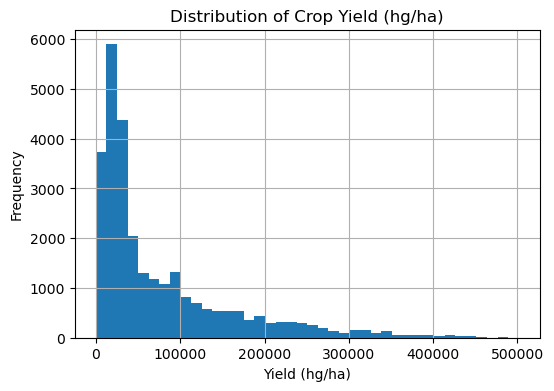

In [49]:
import matplotlib.pyplot as plt

# Yield distribution
plt.figure(figsize=(6,4))
df["hg/ha_yield"].hist(bins=40)
plt.title("Distribution of Crop Yield (hg/ha)")
plt.xlabel("Yield (hg/ha)")
plt.ylabel("Frequency")
plt.show()


### Distribution of Crop Yield (hg/ha)

This histogram shows the distribution of crop yields across all countries, crops, and years in the dataset.

**Key observations:**

- Yield values are **highly right-skewed**, with most samples below 100,000 hg/ha.
- A small number of crop–country–year combinations have **extremely high yields**, forming a long tail up to ~500,000 hg/ha.
- The skew indicates **strong variation in agricultural productivity** depending on region, crop type, and environmental conditions.
- This motivates using **tree-based models** (e.g., Random Forest) that can handle non-linear relationships and wide value ranges.


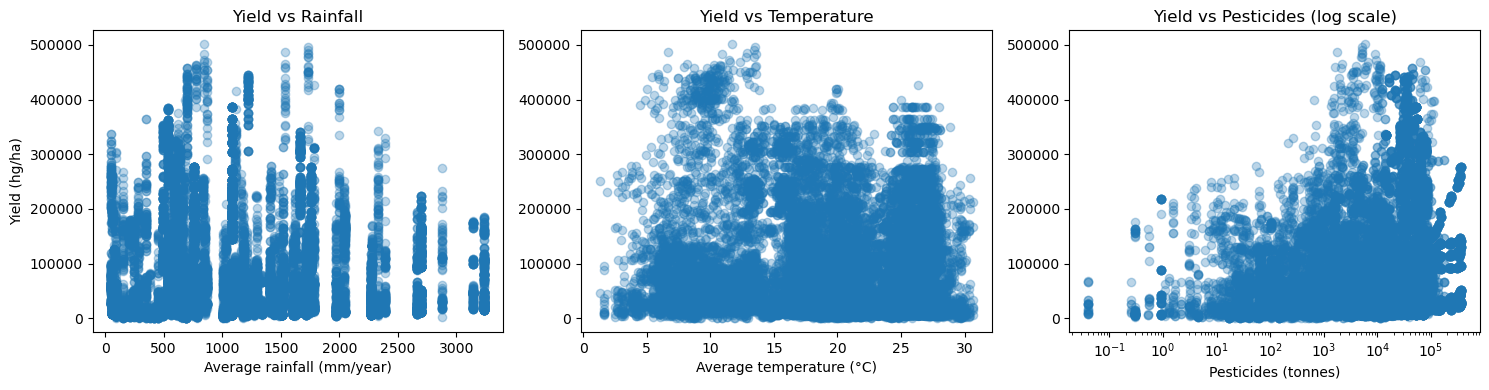

In [50]:
# Scatter plots: yield vs key drivers
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].scatter(df["average_rain_fall_mm_per_year"], df["hg/ha_yield"], alpha=0.3)
axes[0].set_xlabel("Average rainfall (mm/year)")
axes[0].set_ylabel("Yield (hg/ha)")
axes[0].set_title("Yield vs Rainfall")

axes[1].scatter(df["avg_temp"], df["hg/ha_yield"], alpha=0.3)
axes[1].set_xlabel("Average temperature (°C)")
axes[1].set_title("Yield vs Temperature")

axes[2].scatter(df["pesticides_tonnes"], df["hg/ha_yield"], alpha=0.3)
axes[2].set_xlabel("Pesticides (tonnes)")
axes[2].set_xscale("log")
axes[2].set_title("Yield vs Pesticides (log scale)")

plt.tight_layout()
plt.show()


###  Yield vs Rainfall

This scatter plot visualizes the relationship between annual average rainfall and crop yield.

**Insights:**

- Yield generally **increases with rainfall up to a point**, after which it becomes more scattered.
- Countries with rainfall between **800–1500 mm/year** show some of the highest yields.
- There is no simple linear relationship; instead, yield responds in a **non-linear, crop-specific** way to rainfall.
- This supports the choice of models that capture interactions and non-linear effects.


###  Yield vs Temperature

This plot shows how yield varies with average annual temperature.

**Key findings:**

- The dataset covers climates from **~1°C to 30°C**.
- Highest yields tend to appear in **moderate temperature ranges (10–20°C)**.
- Extremely high temperatures often correlate with **lower or more variable yields**, likely due to heat stress on crops.
- The wide spread shows strong **crop-specific behavior**—temperature affects cassava differently from wheat, etc.


###  Yield vs Pesticides (log scale)

This scatter plot explores the impact of pesticide usage on yield, using a log scale due to extreme skew.

**Observations:**

- Pesticide usage ranges from **fractions of a tonne to over 100,000 tonnes**.
- Higher pesticide usage often correlates with **higher yields**, but the relationship is not linear.
- The log scale helps reveal patterns that would otherwise be hidden due to extreme outliers.
- This suggests pesticides act as a **complementary factor**, but not the sole driver of yield.


<Figure size 800x400 with 0 Axes>

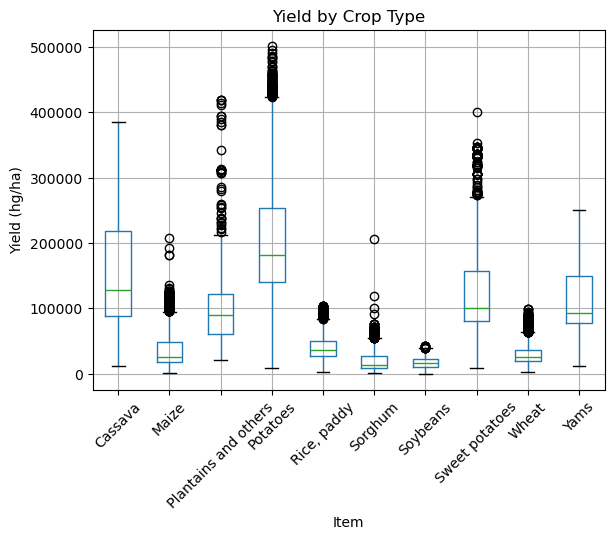

In [51]:
# Yield by crop type (boxplot)
plt.figure(figsize=(8,4))
df.boxplot(column="hg/ha_yield", by="Item", rot=45)
plt.title("Yield by Crop Type")
plt.suptitle("")
plt.ylabel("Yield (hg/ha)")
plt.show()


###  Yield by Crop Type

This boxplot compares yield distributions for major crop types.

**Insights:**

- Crop type is a **major determinant of yield levels**.
- **Rice, plantains, and sweet potatoes** show some of the highest maximum yields.
- **Sorghum and soybeans** tend to have lower, more compact yield distributions.
- Cassava and wheat exhibit **large variability**, indicating strong influence from environmental and regional factors.
- This highlights the importance of including `Item` (crop type) in the model as a categorical feature.


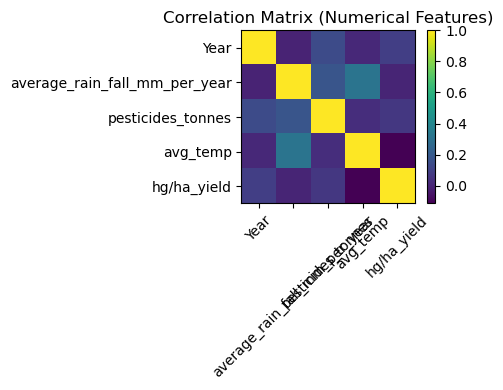

In [52]:
num_cols = ["Year", "average_rain_fall_mm_per_year", "pesticides_tonnes", "avg_temp", "hg/ha_yield"]
corr = df[num_cols].corr()

plt.figure(figsize=(5,4))
plt.imshow(corr, interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation Matrix (Numerical Features)")
plt.tight_layout()
plt.show()


## Preprocessing pipeline

We build a reusable preprocessing pipeline that:
1. Imputes missing numerical values with the median & scales them.
2. Imputes missing categorical values with the most frequent category & one-hot encodes them.
3. Combines everything using a `ColumnTransformer`.

This same pipeline is reused during model training and in the production DSS.


In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("../data/yield_df.csv")

# Drop unnecessary index column
df = df.drop(columns=["Unnamed: 0"])

# --------------------------
# Define target and features
# --------------------------
TARGET = "hg/ha_yield"

X = df.drop(columns=[TARGET])
y = df[TARGET]

# --------------------------
# Identify column types
# --------------------------
categorical_features = ["Area", "Item"]
numerical_features = ["Year", "average_rain_fall_mm_per_year", "pesticides_tonnes", "avg_temp"]

# --------------------------
# Preprocessing steps
# --------------------------

# Numerical Pipeline → impute missing values + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical Pipeline → impute (just in case) + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine them using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# --------------------------
# Train-test split (80/20)
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (22593, 6)
Testing shape: (5649, 6)


In [54]:
from sklearn.linear_model import LinearRegression

lr_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:

from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)


In [ ]:
from xgboost import XGBRegressor

xgb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate(model, name):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"--- {name} ---")
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    print()

evaluate(lr_model, "Linear Regression")
evaluate(rf_model, "Random Forest")
evaluate(xgb_model, "XGBoost")


--- Linear Regression ---
RMSE: 42144.04496876899
MAE: 29582.507897905605
R²: 0.7551418738725029

--- Random Forest ---
RMSE: 9444.533189905202
MAE: 3463.785252257037
R²: 0.9877028893044111

--- XGBoost ---
RMSE: 13763.631497537268
MAE: 8245.13671875
R²: 0.9738839268684387



In [ ]:
import joblib
joblib.dump(xgb_model, "../models/best_model.joblib")


['../models/best_model.joblib']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_metrics(model, name):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}

results = []
results.append(get_metrics(lr_model, "Linear Regression"))
results.append(get_metrics(rf_model, "Random Forest"))
results.append(get_metrics(xgb_model, "XGBoost"))

metrics_df = pd.DataFrame(results)
metrics_df


,Model,RMSE,MAE,R2
0,Linear Regression,42144.044969,29582.507898,0.755142
1,Random Forest,9444.533190,3463.785252,0.987703
2,XGBoost,13763.631498,8245.136719,0.973884


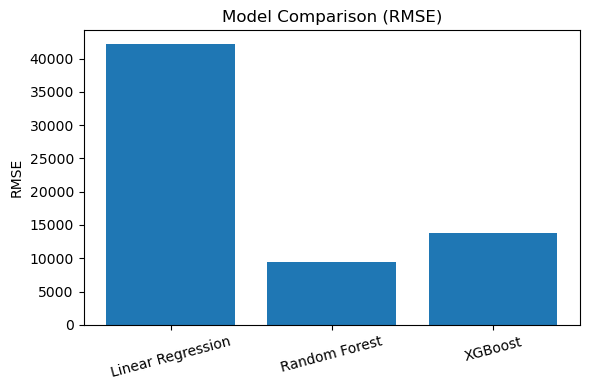

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(metrics_df["Model"], metrics_df["RMSE"])
plt.ylabel("RMSE")
plt.title("Model Comparison (RMSE)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Get feature names after preprocessing
feature_names = rf_model.named_steps["preprocess"].get_feature_names_out()

# Get importances from the RF inside the pipeline
importances = rf_model.named_steps["model"].feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_top10 = fi_df.head(10)
fi_top10


,feature,importance
108,cat__Item_Potatoes,0.369454
105,cat__Item_Cassava,0.102510
112,cat__Item_Sweet potatoes,0.086242
2,num__pesticides_tonnes,0.070366
46,cat__Area_India,0.058438
1,num__average_rain_fall_mm_per_year,0.043001
3,num__avg_temp,0.042237
0,num__Year,0.032753
114,cat__Item_Yams,0.027481
101,cat__Area_United Kingdom,0.017318


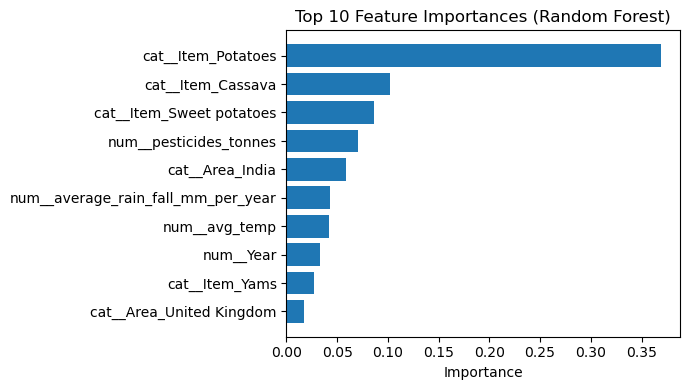

In [ ]:
plt.figure(figsize=(7,4))
plt.barh(fi_top10["feature"], fi_top10["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [ ]:
import joblib

joblib.dump(rf_model, "../models/best_model.joblib")


['../models/best_model.joblib']

In [ ]:
import os, joblib

MODEL_PATH = "../models/best_model.joblib"

if os.path.exists(MODEL_PATH):
    model = joblib.load(MODEL_PATH)
else:
    # train rf_model here and save
    rf_model.fit(X_train, y_train)
    joblib.dump(rf_model, MODEL_PATH)
    model = rf_model
